In [5]:
import os

PROJECT_DIR = '/content/tendencias_empregos_dados'
DATA_DIR = f'{PROJECT_DIR}/data'
OUTPUT_DIR = f'{PROJECT_DIR}/outputs'

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Pastas criadas em:", PROJECT_DIR)




Pastas criadas em: /content/tendencias_empregos_dados


In [6]:
from google.colab import files
uploaded = files.upload()

csv_name = list(uploaded.keys())[0]
csv_name


Saving ds_salaries.csv to ds_salaries.csv


'ds_salaries.csv'

In [7]:
import shutil

src_path = f'/content/{csv_name}'
dst_path = f'{DATA_DIR}/{csv_name}'

shutil.move(src_path, dst_path)

DATA_PATH = dst_path
print("CSV salvo em:", DATA_PATH)


CSV salvo em: /content/tendencias_empregos_dados/data/ds_salaries.csv


In [9]:
!pip -q install pandas matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")
print("Pronto!")



Pronto!


In [10]:

df = pd.read_csv(DATA_PATH)
print("Dimensão:", df.shape)

display(df.head(3))
print("Colunas:", list(df.columns))

colmap_options = [
    {
      'work_year':'work_year',
      'experience_level':'experience_level',
      'employment_type':'employment_type',
      'job_title':'job_title',
      'salary_in_usd':'salary_in_usd',
      'employee_residence':'employee_residence',
      'remote_ratio':'remote_ratio',
      'company_location':'company_location'
    },

    {k:k.upper() for k in [
      'work_year','experience_level','employment_type','job_title',
      'salary_in_usd','employee_residence','remote_ratio','company_location'
    ]}
]


used_map = None
for cand in colmap_options:
    if all([(c in df.columns) for c in cand.values()]):
        used_map = cand
        break

if used_map is None:
    print("⚠️ Não encontrei todas as colunas padrão. Vamos continuar com o que existir.")
    used_map = {c:c for c in df.columns}

rename_pt = {
    used_map.get('work_year','work_year'): 'ano',
    used_map.get('experience_level','experience_level'): 'nivel',
    used_map.get('employment_type','employment_type'): 'tipo_contrato',
    used_map.get('job_title','job_title'): 'cargo',
    used_map.get('salary_in_usd','salary_in_usd'): 'salario_usd',
    used_map.get('company_location','company_location'): 'pais_empresa',
    used_map.get('employee_residence','employee_residence'): 'pais_profissional',
    used_map.get('remote_ratio','remote_ratio'): 'remoto_ratio'
}
df = df.rename(columns=rename_pt)

print("Colunas após renomear:", list(df.columns))


Dimensão: (607, 12)


Unnamed: 0  work_year experience_level employment_type  \
0           0       2020               MI              FT   
1           1       2020               SE              FT   
2           2       2020               SE              FT   

                    job_title  salary salary_currency  salary_in_usd  \
0              Data Scientist   70000             EUR          79833   
1  Machine Learning Scientist  260000             USD         260000   
2           Big Data Engineer   85000             GBP         109024   

  employee_residence  remote_ratio company_location company_size  
0                 DE             0               DE            L  
1                 JP             0               JP            S  
2                 GB            50               GB            M

Colunas: ['Unnamed: 0', 'work_year', 'experience_level', 'employment_type', 'job_title', 'salary', 'salary_currency', 'salary_in_usd', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']
Colunas após renomear: ['Unnamed: 0', 'ano', 'nivel', 'tipo_contrato', 'cargo', 'salary', 'salary_currency', 'salario_usd', 'pais_profissional', 'remoto_ratio', 'pais_empresa', 'company_size']


In [11]:
antes = len(df)


for c in ['ano','salario_usd','remoto_ratio']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')


df = df.drop_duplicates()

req = [c for c in ['salario_usd','ano'] if c in df.columns]
if req:
    df = df.dropna(subset=req)

depois = len(df)
print(f"Linhas removidas: {antes - depois}")
print("Linhas finais:", len(df))

map_nivel = {'EN':'Júnior/Entry','MI':'Pleno/Mid','SE':'Sênior','EX':'Diretoria/Exec'}
if 'nivel' in df.columns:
    df['nivel_legivel'] = df['nivel'].map(map_nivel).fillna(df['nivel'])

def classe_remoto(x):
    try:
        x = float(x)
    except:
        return np.nan
    if x == 0: return 'Presencial'
    if x == 100: return 'Remoto'
    return 'Híbrido'

if 'remoto_ratio' in df.columns:
    df['modalidade'] = df['remoto_ratio'].apply(classe_remoto)

clean_path = f'{OUTPUT_DIR}/jobs_limpo.csv'
os.makedirs(OUTPUT_DIR, exist_ok=True)
df.to_csv(clean_path, index=False)
print("CSV limpo salvo em:", clean_path)


Linhas removidas: 0
Linhas finais: 607
CSV limpo salvo em: /content/tendencias_empregos_dados/outputs/jobs_limpo.csv


In [12]:
if 'ano' in df.columns:
    cont = df['ano'].value_counts().sort_index()
    ax = cont.plot(kind='bar')
    ax.set_title('Quantidade de Vagas por Ano')
    ax.set_xlabel('Ano'); ax.set_ylabel('Qtd de vagas')
    plt.tight_layout()
    fig_path = f'{OUTPUT_DIR}/vagas_por_ano.png'
    plt.savefig(fig_path, dpi=150); plt.show()
    print("Figura salva em:", fig_path)
else:
    print("⚠️ Coluna 'ano' não encontrada.")


Figura salva em: /content/tendencias_empregos_dados/outputs/vagas_por_ano.png


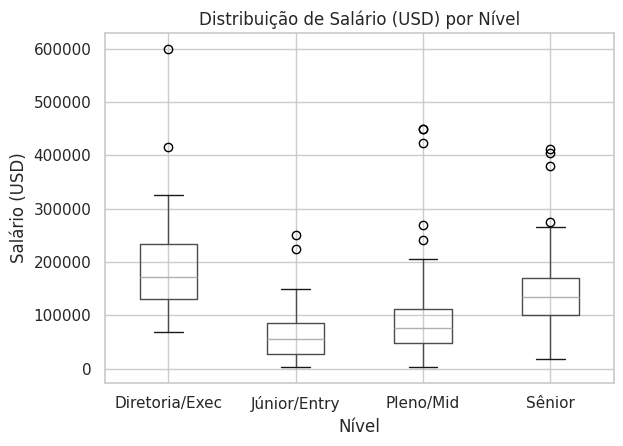

nivel_legivel
Diretoria/Exec    199392.0
Sênior            138617.0
Pleno/Mid          87996.0
Júnior/Entry       61643.0
Name: salario_usd, dtype: float64
Figura salva em: /content/tendencias_empregos_dados/outputs/salario_por_nivel.png


In [13]:
if {'salario_usd','nivel_legivel'}.issubset(df.columns):
    ax = df.boxplot(column='salario_usd', by='nivel_legivel')
    plt.title('Distribuição de Salário (USD) por Nível')
    plt.suptitle(''); plt.xlabel('Nível'); plt.ylabel('Salário (USD)')
    plt.tight_layout()
    fig_path = f'{OUTPUT_DIR}/salario_por_nivel.png'
    plt.savefig(fig_path, dpi=150); plt.show()
    print(df.groupby('nivel_legivel')['salario_usd'].mean().round(0).sort_values(ascending=False))
    print("Figura salva em:", fig_path)
else:
    print("⚠️ Faltam colunas para esse gráfico (salario_usd e/ou nivel_legivel).")


In [14]:
if {'salario_usd','modalidade'}.issubset(df.columns):
    ax = df.boxplot(column='salario_usd', by='modalidade')
    plt.title('Salário (USD) por Modalidade')
    plt.suptitle(''); plt.xlabel('Modalidade'); plt.ylabel('Salário (USD)')
    plt.tight_layout()
    fig_path = f'{OUTPUT_DIR}/salario_por_modalidade.png'
    plt.savefig(fig_path, dpi=150); plt.show()
    print(df.groupby('modalidade')['salario_usd'].mean().round(0))
    print("Figura salva em:", fig_path)
else:
    print("⚠️ Faltam colunas para esse gráfico (salario_usd e/ou modalidade).")


modalidade
Híbrido        80823.0
Presencial    106355.0
Remoto        122457.0
Name: salario_usd, dtype: float64
Figura salva em: /content/tendencias_empregos_dados/outputs/salario_por_modalidade.png


In [15]:
if 'pais_empresa' in df.columns:
    top_paises = df['pais_empresa'].value_counts().head(10)
    ax = top_paises.plot(kind='bar')
    ax.set_title('Top 10 Países por Quantidade de Vagas')
    ax.set_xlabel('País'); ax.set_ylabel('Qtd de vagas')
    plt.tight_layout()
    fig_path = f'{OUTPUT_DIR}/top_paises_vagas.png'
    plt.savefig(fig_path, dpi=150); plt.show()
    print("Figura salva em:", fig_path)

    if 'salario_usd' in df.columns:
        pais_stats = (df.groupby('pais_empresa')
                        .agg(qtd=('pais_empresa','count'),
                             salario_medio=('salario_usd','mean'))
                        .query('qtd >= 30')
                        .sort_values('salario_medio', ascending=False)
                        .round(0))
        display(pais_stats.head(10))
        csv_path = f'{OUTPUT_DIR}/salario_medio_por_pais.csv'
        pais_stats.to_csv(csv_path)
        print("Tabela salva em:", csv_path)
else:
    print("⚠️ Coluna 'pais_empresa' não encontrada.")


Figura salva em: /content/tendencias_empregos_dados/outputs/top_paises_vagas.png


qtd  salario_medio
pais_empresa                    
US            355       144055.0
CA             30        99824.0
GB             47        81583.0

Tabela salva em: /content/tendencias_empregos_dados/outputs/salario_medio_por_pais.csv


In [16]:
resumo = {
    'linhas': [len(df)],
    'anos_disponiveis': [f"{int(df['ano'].min())}–{int(df['ano'].max())}"] if 'ano' in df.columns else ['(não disponível)'],
    'media_salarial_total_usd': [round(df['salario_usd'].mean(), 0)] if 'salario_usd' in df.columns else ['(n/d)']
}
resumo_df = pd.DataFrame(resumo)
res_path = f'{OUTPUT_DIR}/resumo_geral.csv'
resumo_df.to_csv(res_path, index=False)
display(resumo_df)
print("Resumo salvo em:", res_path)


linhas anos_disponiveis  media_salarial_total_usd
0     607        2020–2022                  112298.0

Resumo salvo em: /content/tendencias_empregos_dados/outputs/resumo_geral.csv
